In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
np.random.seed(1234)

In [166]:
def activation_func(x):
    return np.tanh(x)

In [183]:
n_neurons, latent_rank, n_trials, duration = 500, 50, 20, 750
input_tau = .05
times = np.linspace(0, 1, duration)

time_distances = np.exp(-(times[:, None] - times[None, :]) ** 2 / input_tau**2)
input = np.random.multivariate_normal(np.zeros(duration), time_distances)
dt, tau = 0.01, 0.05

J_0 = np.random.randn(n_neurons, n_neurons) / np.sqrt(n_neurons)
U = np.random.randn(n_neurons, latent_rank) / np.sqrt(latent_rank)
V = np.random.randn(n_neurons, latent_rank) / np.sqrt(latent_rank)
I = np.random.randn(n_neurons)
J = J_0 + U @ V.T

In [184]:
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
for ti in range(duration):
    x += dt/tau * (-x + J @ r + (I * input[ti])[:, None])
    r = activation_func(x)
    r_store[:, ti] = r


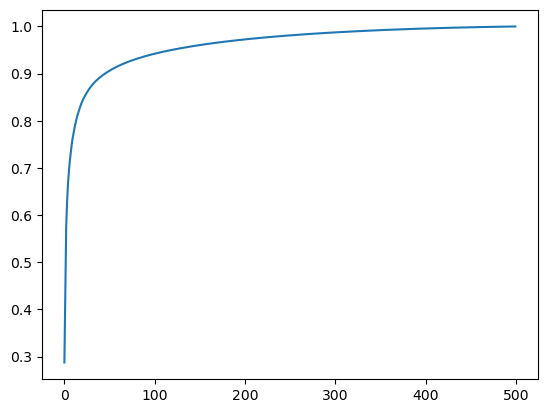

In [185]:
r_flat = r_store.reshape(n_neurons, duration* n_trials).T
pca = PCA()
pca.fit(r_flat)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [186]:
n_trials = 100
noise = np.random.randn(n_neurons, duration, n_trials)
x_0 = np.random.randn(n_neurons, n_trials)
r = activation_func(x_0)
r_store = np.zeros((n_neurons, duration, n_trials))
x = x_0.copy()
for ti in range(duration):
    x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
    r = activation_func(x)
    r_store[:, ti] = r

In [188]:
noise_flat = noise.reshape(n_neurons, duration* n_trials).T
exploration_flat = (r_store - r_store.mean(axis=(0, 2))[None, :, None]).reshape(n_neurons, duration* n_trials).T

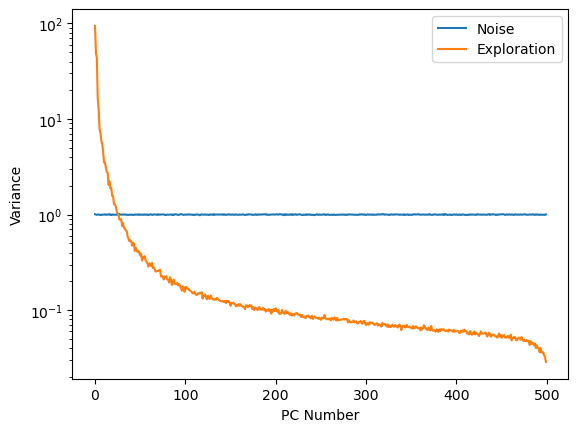

In [189]:
noise_transformed = pca.transform(noise_flat)
exploration_signal_transform = pca.transform(exploration_flat)
var_across = noise_transformed.var(axis=0)
exploration_var_across = exploration_signal_transform.var(axis=0)

plt.plot(var_across, label='Noise')
plt.plot(exploration_var_across, label='Exploration')
plt.xlabel('PC Number')
plt.ylabel('Variance')
plt.yscale('log')
plt.legend()

Obviously this rate of exploration in the higher dimensions will be costly if the rewarding axis is actually one of the higher dimensions and should lead to an exponential speed up in the amount needed to learn. The solution would be to inject variability into the dimensions most correlated with reward.

We'll add another network that uses hebbian and anti-hebbian learning to pull out the PCS from the original network

In [253]:
def create_rectangular_matrix_with_1s_on_diagonal(rows, cols):
  """Creates a rectangular matrix with 1s on the diagonal.

  Args:
    rows: The number of rows in the matrix.
    cols: The number of columns in the matrix.

  Returns:
    A rectangular matrix with 1s on the diagonal.
  """

  matrix = np.zeros((rows, cols))
  for i in range(rows):
    matrix[i, i] = 1
      
  return matrix

In [310]:
n_neurons_bg = int(.1 * n_neurons)
noise_bg = np.random.randn(n_neurons_bg, duration, 1)

W_ff = np.random.randn(n_neurons_bg, n_neurons) / np.sqrt(n_neurons)
W_fb = 0 * np.random.randn(n_neurons_bg, n_neurons_bg) / np.sqrt(n_neurons_bg)
lr = 0.01
trials = 200
diag_mat = create_rectangular_matrix_with_1s_on_diagonal(n_neurons_bg, n_neurons)
for trial in range(trials):
    noise = np.random.randn(n_neurons, duration, 1)
    x_0 = np.random.randn(n_neurons, 1)
    bg_0 = np.random.randn(n_neurons_bg, 1)
    r = activation_func(x_0)
    r_bg = activation_func(bg_0)
    r_store = np.zeros((n_neurons, duration, 1))
    r_bg_store = np.zeros((n_neurons_bg, duration, 1))
    r_mean = np.zeros((n_neurons, 1))
    r_bg_mean = np.zeros((n_neurons_bg, 1))
    x = x_0.copy()
    x_bg = bg_0.copy()
    trace_ff = 0
    trace_fb = 0
    for ti in range(duration):
        x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
        r = activation_func(x)
        r_store[:, ti] = r
        x_bg += dt/tau * (-x_bg + W_ff @ r - W_fb @ r_bg + 0 * noise_bg[:, ti])
        r_bg = activation_func(x_bg / 10)
        r_bg_store[:, ti] = r_bg
        trace_ff += (((r - r_mean) @ (r_bg - r_bg_mean).T).T)
        trace_fb += (((r_bg - r_bg_mean) @ (r_bg - r_bg_mean).T).T)
    W_ff += lr * (trace_ff/duration - W_ff)
    W_fb += lr * (trace_fb/duration - W_fb)
    r_mean = r_store.mean(axis=(1,2))
    r_bg_mean = r_bg_store.mean(axis=(1, 2))
    

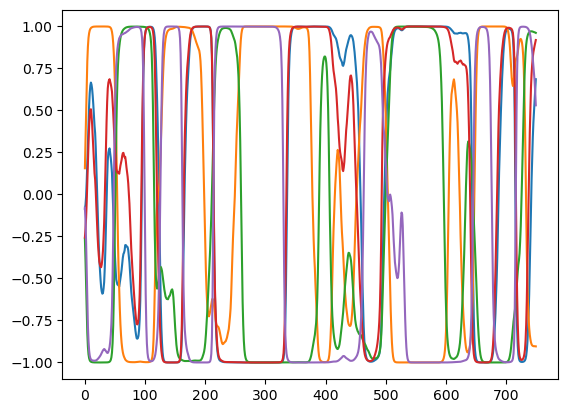

In [311]:
noise = np.random.randn(n_neurons, duration, 1)
noise_bg = np.random.randn(n_neurons_bg, duration, 1)

x_0 = np.random.randn(n_neurons, 1)
bg_0 = np.random.randn(n_neurons_bg, 1)
r = activation_func(x_0)
r_bg = activation_func(bg_0)
r_store = np.zeros((n_neurons, duration, 1))
r_bg_store = np.zeros((n_neurons_bg, duration, 1))
x = x_0.copy()
x_bg = bg_0.copy()
for ti in range(duration):
    x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
    r = activation_func(x)
    r_store[:, ti] = r
    x_bg += dt/tau * (-x_bg + W_ff @ r - W_fb @ r_bg + 0 * noise_bg[:, ti])
    r_bg = activation_func(x_bg / 10)
    r_bg_store[:, ti] = r_bg
pcs = pca.transform(r_store.squeeze().T).T
plt.plot(r_bg_store[:5, :].squeeze().T)

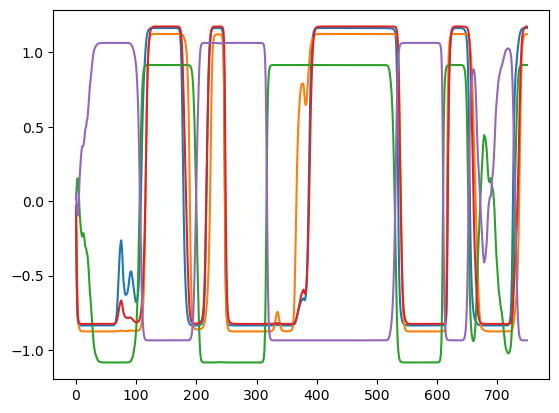

In [358]:
plt.plot(r_bg_store[:5, :].squeeze().T)


In [239]:
def linear_regression(features, targets, kappa: float = 1e-3):
    #expects targets and features to be [features, samples]
    
    # zero mean targets and predictors
    features_mean = features.mean(axis=1)
    target_mean = targets.mean(axis=1)
    features -= features_mean[:, None]
    targets -= target_mean
    
    coeffs = np.linalg.inv(features @ features.T - kappa * np.eye(features.shape[0])) @ features @ targets.T
    model_prediction = (coeffs.T @ features).squeeze()
    corr_coeff = np.corrcoef(model_prediction, targets.squeeze())[0, 1] ** 2
    return coeffs, model_prediction, targets.squeeze(), corr_coeff

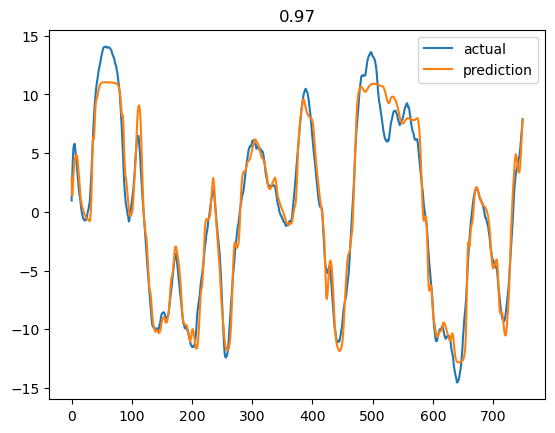

In [297]:
lin_coefs, prediction, actual, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[0][None, :])
plt.title(f"{corr_coeff:.2f}")
plt.plot(actual, label='actual')
plt.plot(prediction, label='prediction')
plt.legend()

In [312]:
score = []
for pc in range(pcs.shape[0]):
    _, _, _, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[pc][None, :])
    score.append(corr_coeff)

Text(0, 0.5, 'Score')

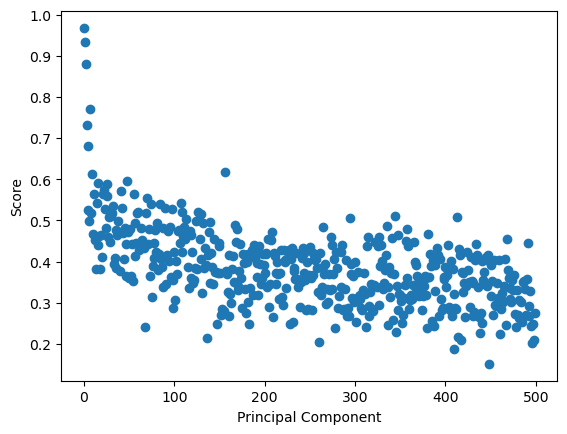

In [313]:
plt.scatter(np.arange(len(score)), score)
plt.xlabel('Principal Component')
plt.ylabel('Score')

Can we shift the extracted PCs with rewards?

In [409]:
n_neurons_bg = int(.1 * n_neurons)
noise_bg = np.random.randn(n_neurons_bg, duration, 1)
rewarded_dim = 50

W_ff = np.random.randn(n_neurons_bg, n_neurons) / np.sqrt(n_neurons)
W_fb = np.random.randn(n_neurons_bg, n_neurons_bg) / np.sqrt(n_neurons_bg)
lr = 0.01
trials = 50
diag_mat = create_rectangular_matrix_with_1s_on_diagonal(n_neurons_bg, n_neurons)
all_rewards = []
for trial in range(trials):
    noise = np.random.randn(n_neurons, duration, 1)
    x_0 = np.random.randn(n_neurons, 1)
    bg_0 = np.random.randn(n_neurons_bg, 1)
    r = activation_func(x_0)
    r_bg = activation_func(bg_0)
    r_store = np.zeros((n_neurons, duration, 1))
    r_bg_store = np.zeros((n_neurons_bg, duration, 1))
    r_mean = np.zeros((n_neurons, 1))
    r_bg_mean = np.zeros((n_neurons_bg, 1))
    x = x_0.copy()
    x_bg = bg_0.copy()
    running_sum = 0
    for ti in range(duration):
        prev_projections = pca.transform(r.T).squeeze()
        x += dt/tau * (-x + J @ r + noise[:, ti] + (I * input[ti])[:, None])
        r = activation_func(x)
        r_store[:, ti] = r
        projections = pca.transform(r.T).squeeze()
        reward_magnitude = ((projections - prev_projections)[rewarded_dim]) ** 2 / np.linalg.norm((projections - prev_projections))
        all_rewards.append(reward_magnitude)
        x_bg = W_ff @ r - W_fb @ r_bg + 0 * noise_bg[:, ti]
        r_bg = activation_func(x_bg / 10)
        r_bg_store[:, ti] = r_bg
        centered_bg = r_bg
        centered_ctx = r - r_mean
        running_sum += r_bg ** 2
        W_ff += (centered_bg @ centered_ctx.T - np.diag(centered_bg[:, 0] ** 2) @ W_ff) / running_sum
        W_fb += (centered_bg @ centered_bg.T - np.diag(centered_bg[:, 0] ** 2) @ W_fb) / running_sum
        np.fill_diagonal(W_fb, 0)
    r_mean = r_store.mean(axis=(1,2))
    r_bg_mean = r_bg_store.mean(axis=(1, 2))

In [411]:
W_fb

array([[ 0.        , -1.        , -1.0000037 , ..., -1.00000369,
         1.0000007 , -0.99999947],
       [-1.        ,  0.        ,  1.0000037 , ...,  1.00000369,
        -1.0000007 ,  0.99999947],
       [-0.99999011,  0.99999011,  0.        , ...,  0.99999995,
        -0.99999162,  0.999989  ],
       ...,
       [-0.99999019,  0.9999902 ,  1.00000005, ...,  0.        ,
        -0.9999917 ,  0.99998909],
       [ 0.9999992 , -0.9999992 , -1.00000371, ..., -1.00000369,
         0.        , -0.99999859],
       [-1.00000048,  1.00000048,  1.00000361, ...,  1.0000036 ,
        -1.0000011 ,  0.        ]])

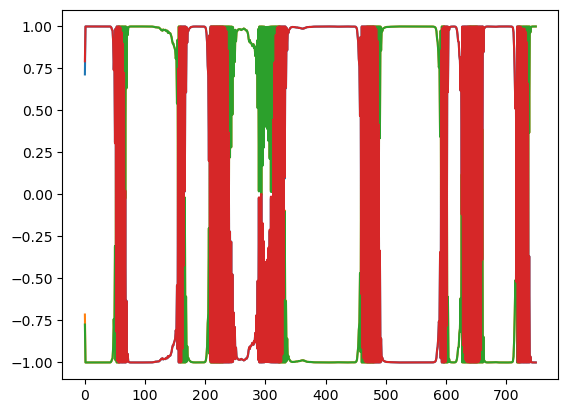

In [412]:
plt.plot(r_bg_store[:4, :].squeeze().T)

In [388]:
test = np.zeros(W_ff.shape)
for i in range(n_neurons_bg):
    for j in range(n_neurons):
        test[i, j] = (r_bg[i] * r[j] - W_ff[i, j] * r_bg[i] ** 2) / (r_bg[i] ** 2)

In [389]:
(test - A)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [369]:
r_bg.shape, r.shape, W_ff.shape, (r  - W_ff.T @ r_bg).shape

((50, 1), (500, 1), (50, 500), (500, 1))

(array([1.33408e+05, 1.27400e+04, 2.85600e+03, 7.30000e+02, 1.99000e+02,
        4.50000e+01, 1.20000e+01, 7.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([4.67899383e-13, 1.87589574e-02, 3.75179148e-02, 5.62768722e-02,
        7.50358297e-02, 9.37947871e-02, 1.12553744e-01, 1.31312702e-01,
        1.50071659e-01, 1.68830617e-01, 1.87589574e-01]),
 <BarContainer object of 10 artists>)

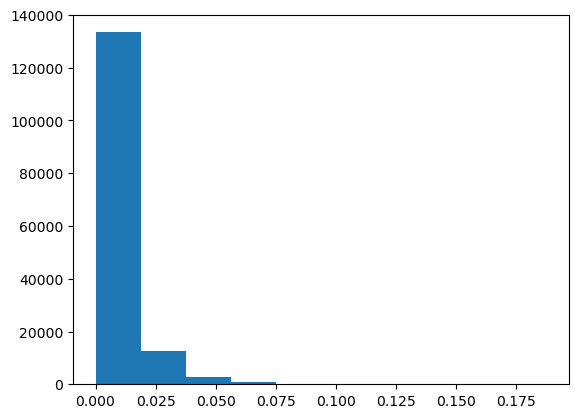

In [346]:
plt.hist(all_rewards)

In [355]:
pcs = pca.transform(r_store.squeeze().T).T
score_reward = []
for pc in range(pcs.shape[0]):
    _, _, _, corr_coeff = linear_regression(r_bg_store.squeeze(), pcs[pc][None, :])
    score_reward.append(corr_coeff)

Text(0, 0.5, 'Score')

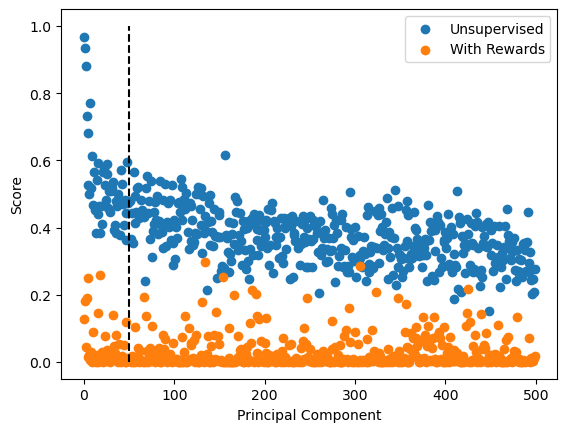

In [356]:
plt.scatter(np.arange(len(score)), score, label='Unsupervised')
plt.scatter(np.arange(len(score_reward)), score_reward, label='With Rewards')
plt.vlines(x=rewarded_dim, ymin=0, ymax=1, color='k', ls='--')
plt.legend(loc='best')
plt.xlabel('Principal Component')
plt.ylabel('Score')

Text(0, 0.5, 'Log Increase')

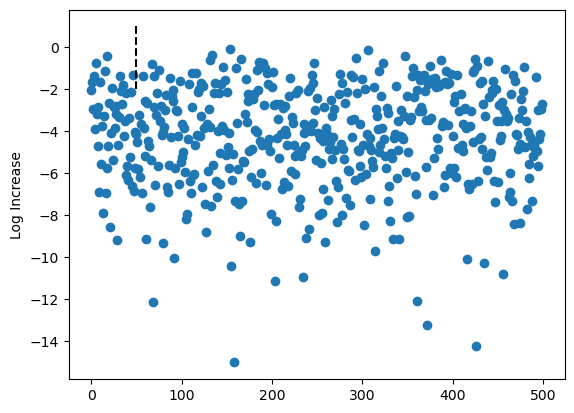

In [357]:
unsupervised = np.asarray(score)
rewarded = np.asarray(score_reward)

plt.scatter(np.arange(rewarded.shape[0]), np.log(rewarded) - np.log(unsupervised))
plt.vlines(x=rewarded_dim, ymin=-2, ymax=1, color='k', ls='--')
plt.ylabel('Log Increase')